# Project Description

# Part 1: Data Preparation

In [1]:
import pandas as pd

df = pd.read_csv('KAG_energydata_complete.csv', index_col=0)
print(df.shape)
print(df.columns)
print(df.head(10))
df.info()

(19735, 28)
Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')
                     Appliances  lights         T1       RH_1     T2  \
date                                                                   
2016-01-11 17:00:00          60      30  19.890000  47.596667  19.20   
2016-01-11 17:10:00          60      30  19.890000  46.693333  19.20   
2016-01-11 17:20:00          50      30  19.890000  46.300000  19.20   
2016-01-11 17:30:00          50      40  19.890000  46.066667  19.20   
2016-01-11 17:40:00          60      40  19.890000  46.333333  19.20   
2016-01-11 17:50:00          50      40  19.890000  46.026667  19.20   
2016-01-11 18:00:00          60      50  19.890000  45.766667  19.20   
2016-01-11 18:10:00          60      50  19.856667 

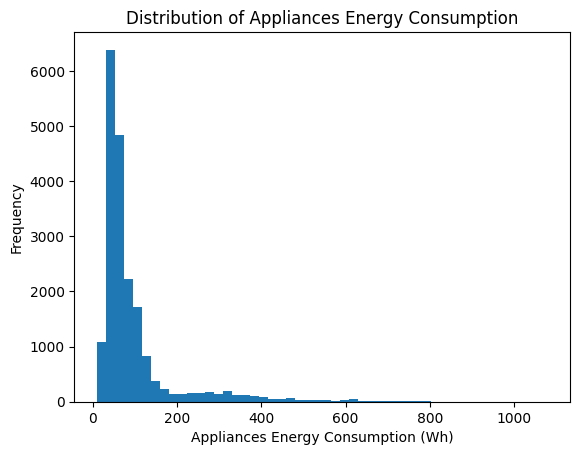

In [2]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df['Appliances'], bins=50)
plt.xlabel('Appliances Energy Consumption (Wh)')
plt.ylabel('Frequency')
plt.title('Distribution of Appliances Energy Consumption')
plt.show()

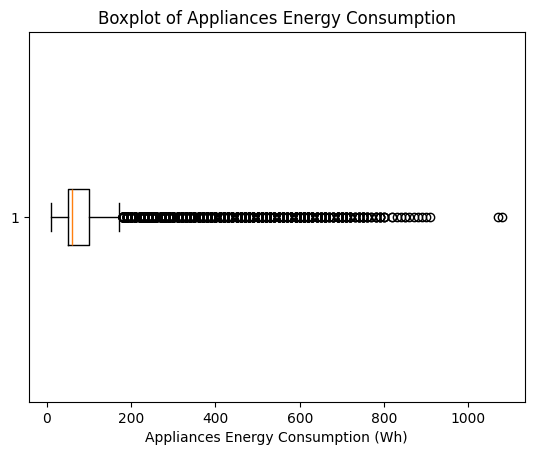

In [3]:
plt.figure()
plt.boxplot(df['Appliances'], vert=False)
plt.xlabel('Appliances Energy Consumption (Wh)')
plt.title('Boxplot of Appliances Energy Consumption')
plt.show()

According to the plots, the target variable exhibits a large number of extreme values, indicating the presence of high energy consumption spikes that should be explicitly considered in the modeling process.

# Part 2: Feature Engineering

## 1. Time features

In [68]:
import numpy as np

In [69]:
df = df.copy()
df.index = pd.to_datetime(df.index)

In [70]:
# extract basic time features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek  
df['month'] = df.index.month
df['day_of_month'] = df.index.day
df['day_of_year'] = df.index.dayofyear

In [71]:
# weekend or not
df['is_weekend'] = np.where(df.index.dayofweek >= 5, 'weekend', 'weekday')

In [72]:
conditions = [
    (df['hour'] >= 6) & (df['hour'] < 12),
    (df['hour'] >= 12) & (df['hour'] < 18),
    (df['hour'] >= 18) & (df['hour'] < 24)
]

choices = ['morning', 'afternoon', 'evening']

df['time_period'] = np.select(conditions, choices, default='night')


In [73]:
# to encode periodic time features

"""
In order to capture periodic patterns, we apply cyclical encoding using sine and cosine transformations. 
This converts discrete time units into continuous circular coordinates.
It maintains the proximity between adjacent periods and eliminating artificial discontinuities at period boundaries.

"""

# hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# week
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# day of month
df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 30)
df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 30)

# day of year
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 366)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 366)

## 2. Temperature features

In [74]:
df["T_indoor_avg"] = df[df.filter(like='T').columns.drop('T6','T_out')].mean(axis=1) # average temperature of 8 rooms
df["T_indoor_std"] = df[df.filter(like='T').columns.drop('T6','T_out')].std(axis=1) # standard error of temperature of 8 rooms
df["T_indoor_max"] = df[df.filter(like='T').columns.drop('T6','T_out')].max(axis=1) # maximum temperature of 8 rooms
df["T_indoor_min"] = df[df.filter(like='T').columns.drop('T6','T_out')].min(axis=1) # minimum temperature of 8 rooms
df["T_indoor_range"] = df["T_indoor_max"] - df["T_indoor_min"] # the range of indoor temperature
df['T_indoor_change'] = df['T_indoor_avg'].diff() # change rate of indoor temperature

In [75]:
# the difference between indoor and outdoor temperatures
df["T_diff_1"] = df["T_indoor_avg"] - df["T6"]
df["T_diff_2"] = df["T_indoor_avg"] - df["T_out"]

## 3. Humidity features

In [76]:
df["RH_indoor_avg"] = df[df.filter(like='RH').columns.drop('RH_6','RH_out')].mean(axis=1) # average humidity of 8 rooms
df["RH_indoor_std"] = df[df.filter(like='RH').columns.drop('RH_6','RH_out')].std(axis=1) # standard error of humidity of 8 rooms
df["RH_indoor_max"] = df[df.filter(like='RH').columns.drop('RH_6','RH_out')].max(axis=1) # maximum humidity of 8 rooms
df["RH_indoor_min"] = df[df.filter(like='RH').columns.drop('RH_6','RH_out')].min(axis=1) # minimum humidity of 8 rooms
df["RH_indoor_range"] = df["RH_indoor_max"] - df["RH_indoor_min"] # the range of indoor humidity
df['RH_indoor_change'] = df['RH_indoor_avg'].diff() # change rate of indoor humidity

In [77]:
# the difference between indoor and outdoor humidity
df["RH_diff_1"] = df["RH_indoor_avg"] - df["RH_6"]
df["RH_diff_2"] = df["RH_indoor_avg"] - df["RH_out"]

In [78]:
pip install metpy

Note: you may need to restart the kernel to use updated packages.


In [79]:
# comfort measures
import metpy.calc as mpcalc
from metpy.calc import heat_index
from metpy.units import units
temp = df["T_indoor_avg"].values * units.degC
humidity = df["RH_indoor_avg"].values * units.percent

# heat index
df["heat_index"] = heat_index(temp, humidity)

# dewpoint
df["dewpoint"] = mpcalc.dewpoint_from_relative_humidity(temp, humidity)

## 4. Weather measures

In [80]:
# weather comprehensive measure
df["weather_com"] = df["T_out"].values * df["RH_out"].values *0.01 * df["Windspeed"].values

In [81]:
# change rate
df['T6_change'] = df['T6'].diff()
df['T_out_change'] = df['T_out'].diff()
df['RH_6_change'] = df['RH_6'].diff()
df['RH_out_change'] = df['RH_out'].diff()
df['Press_change'] = df['Press_mm_hg'].diff()
df['Windspeed_change'] = df['Windspeed'].diff()

## 5. Lag features (without target)

In [82]:
# lights lag
df['lights_lag1'] = df['lights'].shift(1)  
df['lights_lag2'] = df['lights'].shift(2)  
df['lights_lag3'] = df['lights'].shift(3)
df['lights_lag4'] = df['lights'].shift(6)
df['lights_lag5'] = df['lights'].shift(144)

In [83]:
# weather lag
df['T_indoor_lag1'] = df['T_indoor_avg'].shift(1)
df['T_indoor_lag6'] = df['T_indoor_avg'].shift(6)

df['T_out_lag1'] = df['T_out'].shift(1)
df['T_out_lag6'] = df['T_out'].shift(6)

## 6. Rolling features (without target)

In [84]:
# lights rolling
df['lights_rolling_mean_3'] = df['lights'].rolling(window=3, min_periods=1).mean()
df['lights_rolling_mean_6'] = df['lights'].rolling(window=6, min_periods=1).mean()
df['lights_rolling_mean_12'] = df['lights'].rolling(window=12, min_periods=1).mean()
df['lights_rolling_mean_18'] = df['lights'].rolling(window=18, min_periods=1).mean()
df['lights_rolling_max_6'] = df['lights'].rolling(window=6, min_periods=1).max()
df['lights_rolling_min_6'] = df['lights'].rolling(window=6, min_periods=1).min()
df['lights_rolling_std_18'] = df['lights'].rolling(window=18, min_periods=1).std()
df['lights_rolling_std_36'] = df['lights'].rolling(window=36, min_periods=1).std()

In [85]:
# weather rolling
df['T_indoor_rolling_mean_6'] = df['T_indoor_avg'].rolling(window=6, min_periods=1).mean()
df['T_indoor_rolling_max_6'] = df['T_indoor_avg'].rolling(window=6, min_periods=1).max()
df['T_indoor_rolling_min_6'] = df['T_indoor_avg'].rolling(window=6, min_periods=1).min()
df['T_indoor_rolling_std_6'] = df['T_indoor_avg'].rolling(window=6, min_periods=1).std()

df['T_out_rolling_mean_6'] = df['T_out'].rolling(window=6, min_periods=1).mean()
df['T_out_rolling_std_6'] = df['T_out'].rolling(window=6, min_periods=1).std()

## 7. Target variable rolling/lag

In [86]:
# split train and test dataset
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Appliances"]) 
y = np.log1p(df["Appliances"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [87]:
# appliance lag
target_col = 'Appliances'

X_train[f'{target_col}_lag1']   = y_train.shift(1)
X_train[f'{target_col}_lag2']   = y_train.shift(2)
X_train[f'{target_col}_lag3']   = y_train.shift(3)
X_train[f'{target_col}_lag6']   = y_train.shift(6)
X_train[f'{target_col}_lag144'] = y_train.shift(144)

valid_idx = X_train.dropna().index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

In [88]:
# appliance rolling
X_train[f'{target_col}_rolling_mean_3']  = y_train.rolling(3,  min_periods=1).mean().shift(1)
X_train[f'{target_col}_rolling_mean_6']  = y_train.rolling(6,  min_periods=1).mean().shift(1)
X_train[f'{target_col}_rolling_mean_12'] = y_train.rolling(12, min_periods=1).mean().shift(1)
X_train[f'{target_col}_rolling_mean_18'] = y_train.rolling(18, min_periods=1).mean().shift(1)

X_train[f'{target_col}_rolling_max_6'] = y_train.rolling(6, min_periods=1).max().shift(1)
X_train[f'{target_col}_rolling_min_6'] = y_train.rolling(6, min_periods=1).min().shift(1)

X_train[f'{target_col}_rolling_std_18'] = y_train.rolling(18, min_periods=1).std().shift(1)
X_train[f'{target_col}_rolling_std_36'] = y_train.rolling(36, min_periods=1).std().shift(1)

X_train[f'{target_col}_rolling_range_6'] = (
    y_train.rolling(6, min_periods=1).max()
    - y_train.rolling(6, min_periods=1).min()
).shift(1)

X_train[f'{target_col}_diff_1'] = y_train.diff(1).shift(1)

valid_idx = X_train.dropna().index
X_train = X_train.loc[valid_idx]
y_train = y_train.loc[valid_idx]

# Part 3: Feature Analysis

In [89]:
train_df = X_train.copy()
train_df["Appliances"] = y_train

In [90]:
# correlation-based feature selection
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train_df[numeric_cols].corr()
corr_with_target = corr_matrix[target_col].drop(target_col, errors='ignore')

k = 60
top_k = corr_with_target.abs().sort_values(ascending=False)[:k].index

selected_target_corr = corr_with_target[top_k].sort_values(ascending=False)
for i, (feature, corr) in enumerate(selected_target_corr.items(), 1):
    sign = "+" if corr > 0 else "-"
    print(f"{i:2d}. {feature:35s}: {corr:7.4f} ({sign})")

 1. Appliances_lag1                    :  0.8335 (+)
 2. Appliances_rolling_mean_3          :  0.7697 (+)
 3. Appliances_rolling_mean_6          :  0.7206 (+)
 4. Appliances_rolling_max_6           :  0.7188 (+)
 5. Appliances_lag2                    :  0.6988 (+)
 6. Appliances_rolling_mean_12         :  0.6810 (+)
 7. Appliances_rolling_mean_18         :  0.6317 (+)
 8. Appliances_rolling_min_6           :  0.6190 (+)
 9. Appliances_lag3                    :  0.6078 (+)
10. Appliances_lag6                    :  0.5039 (+)
11. Appliances_rolling_std_18          :  0.4760 (+)
12. Appliances_rolling_range_6         :  0.4106 (+)
13. Appliances_rolling_std_36          :  0.3818 (+)
14. Appliances_lag144                  :  0.3564 (+)
15. lights_rolling_max_6               :  0.3113 (+)
16. lights_rolling_mean_3              :  0.3018 (+)
17. lights                             :  0.2891 (+)
18. lights_rolling_mean_6              :  0.2861 (+)
19. T_indoor_change                    :  0.28

1. The strong correlation between the target variable and its lagged and rolling statistics indicates autocorrelation, which is consistent with the persistent nature of residential appliance usage.  
2. "Lights" feature is a behavorial proxy rather than a main driver as its correlation score is not high.

In [91]:
# Bottom correlation features
all_correlations = corr_with_target.abs().sort_values(ascending=False)
print(all_correlations.tail(20))

day_of_year_cos     0.052351
T_indoor_range      0.051884
day_of_month_sin    0.051309
Windspeed_change    0.046524
Tdewpoint           0.046503
RH_indoor_change    0.045365
day_of_week_cos     0.042644
day_of_week_sin     0.033620
T6_change           0.030296
dewpoint            0.028204
RH_4                0.024503
T_indoor_min        0.023001
RH_out_change       0.022406
RH_6_change         0.019527
Visibility          0.014546
RH_5                0.011519
T_out_change        0.008044
rv2                 0.005528
rv1                 0.005528
RH_3                0.001637
Name: Appliances, dtype: float64


AS the correlation results between rv1/rv2 and the target are approximately zero, we can delete these two random variables.

In [92]:
X_train = X_train.drop(columns=["rv1","rv2"]) 

# Part 4: Train model

## 1. Classify features into different groups

In [93]:
import re

In [94]:
all_features = X_train.columns  

feature_categories = {
    'Lights': [f for f in all_features if 'lights' in f],

    'Appliances': [f for f in all_features if f.startswith('Appliances_')],

    'Indoor': [
        f for f in all_features
        if (
        (
            f.startswith('T_indoor')
            or f.startswith('RH_indoor')
            or re.fullmatch(r'T\d+', f)         
            or re.fullmatch(r'RH_\d+', f)        
            or f == 'dewpoint'
        )
        and f not in ['T6', 'RH_6']
        and ('rolling' not in f and 'lag' not in f)
    )
    ],

    'Outdoor/Weather': [
        f for f in all_features if f in [
            'T_out', 'RH_out', 'Press_mm_hg', 'Press_change',
            'Windspeed', 'Windspeed_change', 'Visibility',
            'Tdewpoint', 'heat_index', 'weather_com'
        ]
    ],

    'Time': [
        f for f in all_features if f in [
            'hour', 'day_of_week', 'month', 'day_of_month', 'day_of_year',
            'is_weekend', 'time_period',
            'hour_sin', 'hour_cos',
            'day_of_week_sin', 'day_of_week_cos',
            'month_sin', 'month_cos',
            'day_of_month_sin', 'day_of_month_cos',
            'day_of_year_sin', 'day_of_year_cos'
        ]
    ],

    'lagging/rolling': [
        f for f in all_features
        if (
            ('lag' in f or 'rolling' in f)
            and not f.startswith('Appliances_')
            and 'lights' not in f
        )
    ]
}

outdoor_features = [
    'T6', 'RH_6',
    'T_diff_1', 'T_diff_2',
    'RH_diff_1', 'RH_diff_2',
    'T_out_change', 'T6_change',
    'RH_6_change', 'RH_out_change'
]

feature_categories['Outdoor/Weather'].extend(
    [f for f in outdoor_features if f in all_features]
)

for cat, feats in feature_categories.items():
    print(f"{cat}: {len(feats)} features")


Lights: 14 features
Appliances: 15 features
Indoor: 29 features
Outdoor/Weather: 20 features
Time: 17 features
lagging/rolling: 10 features


## 2. feature selection

In [ ]:
# split the validation dataset
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [97]:
from catboost import CatBoostRegressor

In [100]:
X_train['is_weekend'] = X_train['is_weekend'].astype('category')
X_train['time_period'] = X_train['time_period'].astype('category')


In [141]:
model_cat = CatBoostRegressor(
    cat_features = ['is_weekend', 'time_period'],
    iterations=1000,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=False
)
model_cat.fit(X_train_sub, y_train_sub)

In [142]:
#select features using feature importance
selected_features_by_category = {}
all_selected_features_set = set()

for group_name, features in feature_categories.items():
    num_to_select = max(1, len(features) // 2)  
    selected = model_cat.select_features(
        X=X_train_sub,
        y=y_train_sub,
        features_for_select=features,
        num_features_to_select=num_to_select,  
        algorithm='RecursiveByShapValues',
        steps=4,
        train_final_model=False,
        logging_level='Silent'
    )

    unique_feats = [f for f in selected['selected_features'] if f not in all_selected_features_set]
    selected_features_by_category[group_name] = unique_feats
    all_selected_features_set.update(unique_feats)

selected_features_by_category_names = {}
for category, feats in selected_features_by_category.items():
    feat_names = [X_train.columns[f] if isinstance(f, int) else f for f in feats]
    selected_features_by_category_names[category] = feat_names

for category, feat_names in selected_features_by_category_names.items():
    print(f"{category}: {feat_names}")

Lights: ['lights', 'lights_lag5', 'lights_rolling_mean_6', 'lights_rolling_mean_18', 'lights_rolling_std_18', 'lights_rolling_std_36', 'lights_lag1']
Appliances: ['Appliances_diff_1', 'Appliances_lag1', 'Appliances_lag3', 'Appliances_rolling_mean_3', 'Appliances_rolling_mean_6', 'Appliances_rolling_mean_12', 'Appliances_rolling_mean_18']
Indoor: ['dewpoint', 'RH_1', 'T2', 'RH_2', 'RH_3', 'T4', 'RH_4', 'T_indoor_std', 'T_indoor_max', 'T8', 'RH_8', 'T_indoor_change', 'RH_indoor_avg', 'RH_indoor_change']
Outdoor/Weather: ['T6_change', 'T_out_change', 'RH_6_change', 'RH_out_change', 'Press_change', 'Windspeed_change', 'Press_mm_hg', 'Visibility', 'RH_diff_1', 'RH_diff_2']
Time: ['day_of_week_sin', 'day_of_year_sin', 'day_of_year_cos', 'hour', 'day_of_month', 'day_of_year', 'hour_sin', 'hour_cos']
lagging/rolling: ['T_indoor_rolling_min_6', 'T_indoor_rolling_std_6', 'T_out_rolling_std_6', 'T_indoor_lag6', 'T_out_lag6']


In [143]:
selected_feature_names_cat = []
mandatory_features = ['is_weekend', 'time_period']

for feat_names in selected_features_by_category_names.values():
    selected_feature_names_cat.extend(feat_names)

for f in mandatory_features:
    if f in X_train_sub.columns and f not in selected_feature_names_cat:
        selected_feature_names_cat.append(f)

X_train_sub_selected_features = X_train_sub[selected_feature_names_cat]
model_cat.fit(X_train_sub_selected_features, y_train_sub)


In [144]:
# final feature selection using permutation importance
# calculate pfi
from sklearn.inspection import permutation_importance
pfi_result = permutation_importance(
    model_cat, 
    X_train_sub_selected_features, 
    y_train_sub, 
    n_repeats=15,  
    random_state=42,
    scoring='neg_root_mean_squared_error'  
)
feature_importance_df = pd.DataFrame({
    'feature': X_train_sub_selected_features.columns,
    'importance': pfi_result.importances_mean
}).sort_values(by='importance', ascending=False)

print("PFI ranking of SHAP-selected features:")
print(feature_importance_df)


PFI ranking of SHAP-selected features:
                       feature  importance
8              Appliances_lag1    0.340678
12  Appliances_rolling_mean_12    0.041662
7            Appliances_diff_1    0.036866
10   Appliances_rolling_mean_3    0.030317
0                       lights    0.024820
9              Appliances_lag3    0.020033
11   Appliances_rolling_mean_6    0.018474
13  Appliances_rolling_mean_18    0.015744
45                    hour_cos    0.012687
44                    hour_sin    0.010362
28                   T6_change    0.008576
27            RH_indoor_change    0.008116
25             T_indoor_change    0.007624
21                T_indoor_std    0.007171
17                        RH_2    0.007091
15                        RH_1    0.007040
18                        RH_3    0.006688
30                 RH_6_change    0.006078
47      T_indoor_rolling_std_6    0.005443
19                          T4    0.005400
26               RH_indoor_avg    0.004892
34             

In [145]:
# PFI importance ranking by category
pfi_by_category = {}

for category, feat_names in selected_features_by_category_names.items():
    df_cat = feature_importance_df[
        feature_importance_df['feature'].isin(feat_names)
    ].sort_values(by='importance', ascending=False)

    pfi_by_category[category] = df_cat

for category, df_cat in pfi_by_category.items():
    print(f"\nCategory: {category}")
    print(df_cat)


Category: Lights
                  feature  importance
0                  lights    0.024820
4   lights_rolling_std_18    0.003458
5   lights_rolling_std_36    0.002281
2   lights_rolling_mean_6    0.002207
3  lights_rolling_mean_18    0.002009
1             lights_lag5    0.001855
6             lights_lag1    0.001252

Category: Appliances
                       feature  importance
8              Appliances_lag1    0.340678
12  Appliances_rolling_mean_12    0.041662
7            Appliances_diff_1    0.036866
10   Appliances_rolling_mean_3    0.030317
9              Appliances_lag3    0.020033
11   Appliances_rolling_mean_6    0.018474
13  Appliances_rolling_mean_18    0.015744

Category: Indoor
             feature  importance
27  RH_indoor_change    0.008116
25   T_indoor_change    0.007624
21      T_indoor_std    0.007171
17              RH_2    0.007091
15              RH_1    0.007040
18              RH_3    0.006688
19                T4    0.005400
26     RH_indoor_avg    0.0048

C:\Users\hp\AppData\Local\Temp\ipykernel_5004\1983940372.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y_hourly = y_train.resample('1H').mean().fillna(method='ffill')
C:\Users\hp\AppData\Local\Temp\ipykernel_5004\1983940372.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_hourly = y_train.resample('1H').mean().fillna(method='ffill')


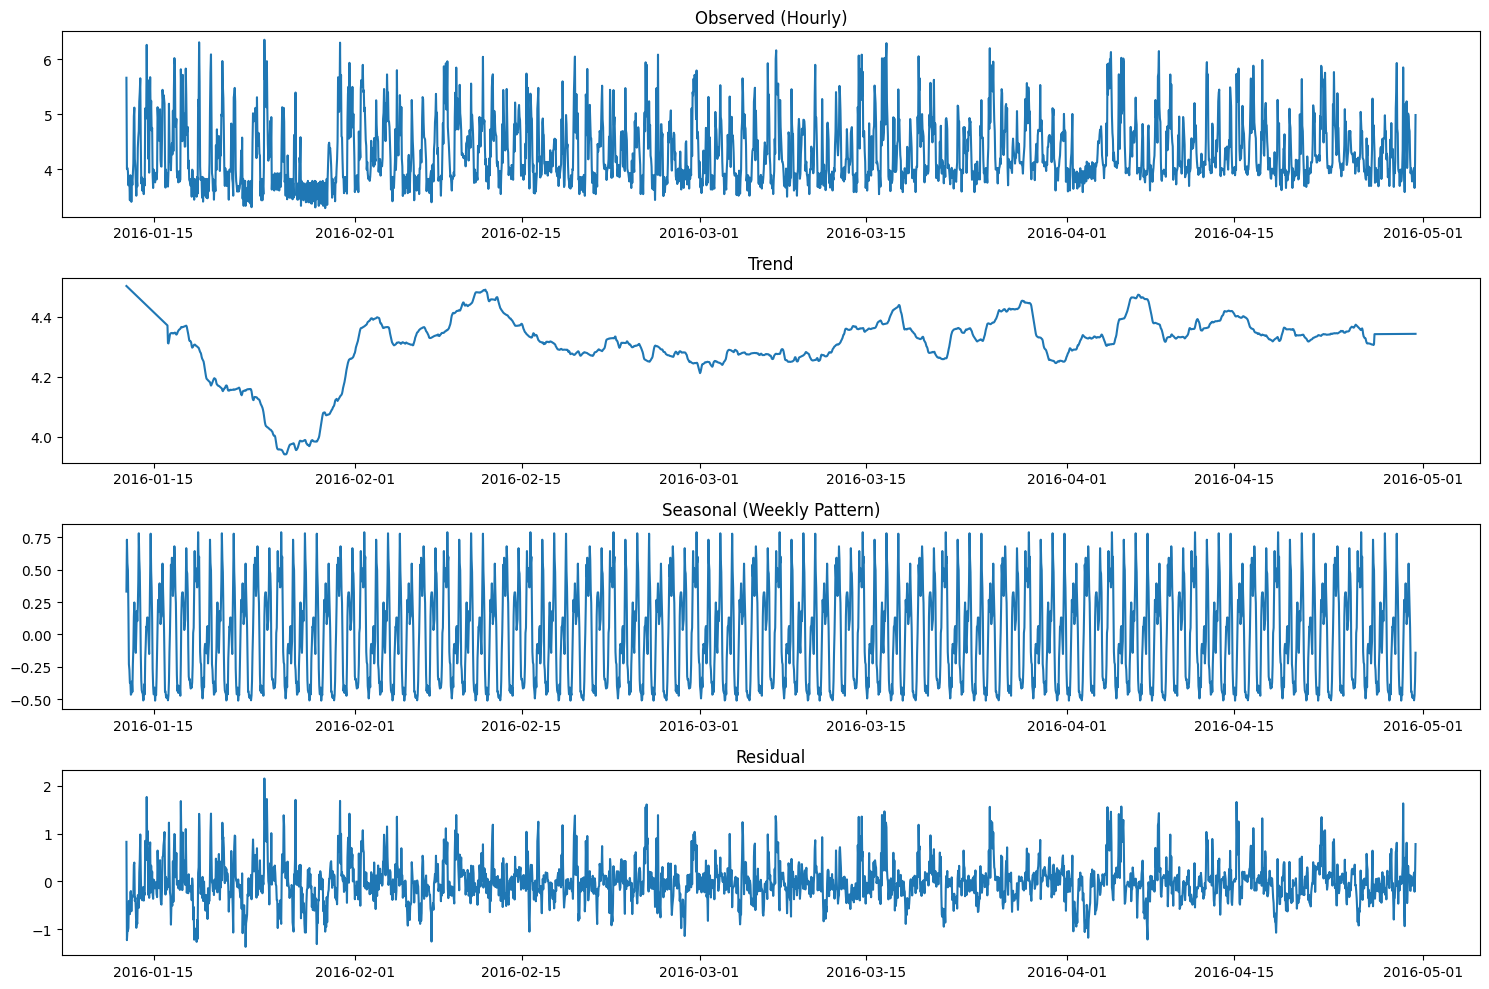

Daily (24h) Seasonal/Trend std: 1.525
Weekly (168h) Seasonal/Trend std: 3.587
Bi-weekly (336h) Seasonal/Trend std: 4.391


In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose

# resample as hour data
y_hourly = y_train.resample('1H').mean().fillna(method='ffill')

# seasonal decomposition for weekly pattern
decomposition = seasonal_decompose(
    y_hourly,
    model='additive',
    period=24*7,  
    extrapolate_trend='freq'
)

fig, axes = plt.subplots(4, 1, figsize=(15, 10))
axes[0].plot(decomposition.observed)
axes[0].set_title('Observed (Hourly)')
axes[1].plot(decomposition.trend)
axes[1].set_title('Trend')
axes[2].plot(decomposition.seasonal)
axes[2].set_title('Seasonal (Weekly Pattern)')
axes[3].plot(decomposition.resid)
axes[3].set_title('Residual')
plt.tight_layout()
plt.show()

# compute seasonal strength for multiple periods
periods_to_check = {
    'Daily (24h)': 24,
    'Weekly (168h)': 24*7,
    'Bi-weekly (336h)': 24*14
}

for name, period in periods_to_check.items():
    decomp = seasonal_decompose(
        y_hourly,
        model='additive',
        period=period,
        extrapolate_trend='freq'
    )
    trend_std = np.nanstd(decomp.trend)
    seasonal_std = np.nanstd(decomp.seasonal)
    if trend_std > 0:
        seasonal_strength = seasonal_std / trend_std
        print(f"{name} Seasonal/Trend std: {seasonal_strength:.3f}")
    else:
        print(f"Can't calculate {name} seasonal strength")

In [146]:
X_val.shape

(3129, 105)

In [168]:
from sklearn.metrics import mean_squared_error

# categorical features
cat_features = ['is_weekend', 'time_period']

# validation parameters
validation_window = 1008  
expanding_step = 336      
metric = mean_squared_error

# top_k per category
top_k_per_category = {
    'Lights': 2,
    'Appliances': 4,
    'Indoor': 4,
    'Outdoor/Weather': 3,
    'Time': 2,
    'lagging/rolling': 3
}

# Step 1: build base features (mandatory + top-K per category)
base_features = mandatory_features.copy()
for cat, df in pfi_by_category.items():
    k = top_k_per_category.get(cat, len(df))
    top_feats = df['feature'].tolist()[:k]
    for f in top_feats:
        if f not in base_features:
            base_features.append(f)

# Step 2: build remaining features sorted by global PFI
all_features_sorted = []
for cat, df in pfi_by_category.items():
    all_features_sorted.extend(df['feature'].tolist())

remaining_features = [f for f in all_features_sorted if f not in base_features]

# Step 3: Expanding window CV
X_data = X_val.copy()
y_data = y_val.copy()
n_samples = X_data.shape[0]

cv_results = []

# Loop over number of extra features to add from remaining_features
for num_extra in range(0, len(remaining_features) + 1):
    
    selected_features = base_features + remaining_features[:num_extra]
    
    fold_scores = []
    val_start = 0
    val_end = validation_window
    fold_count = 0

    while val_end <= n_samples:
        # Expanding window
        X_train_fold = X_data.iloc[:val_start][selected_features]
        y_train_fold = y_data.iloc[:val_start]

        X_val_fold = X_data.iloc[val_start:val_end][selected_features]
        y_val_fold = y_data.iloc[val_start:val_end]

        if X_train_fold.shape[0] < 500:  
            val_start += expanding_step
            val_end = val_start + validation_window
            continue

        try:
            # Train CatBoost
            model_cat = CatBoostRegressor(
                cat_features=cat_features,
                iterations=2500,  
                depth=8,
                learning_rate=0.05,
                l2_leaf_reg=1,
                bagging_temperature=0.5,
                loss_function='RMSE',
                eval_metric='RMSE',
                use_best_model=True,
                early_stopping_rounds=150,
                random_seed=42,
                verbose=False
            )

            model_cat.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold))

            # Predict and calculate RMSE
            y_pred = model_cat.predict(X_val_fold)
            score = np.sqrt(metric(y_val_fold, y_pred))
            fold_scores.append(score)
            fold_count += 1

        except Exception as e:
            print(f"  Error in fold {fold_count} with {len(selected_features)} features: {str(e)}")

        # Slide the window
        val_start += expanding_step
        val_end = val_start + validation_window

    if fold_scores:
        mean_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)
        cv_results.append({
            'num_features': len(selected_features), 
            'features': selected_features.copy(), 
            'rmse_mean': mean_score,
            'rmse_std': std_score,
            'n_folds': fold_count
        })
        print(f"Features: {len(selected_features):2d} | Folds: {fold_count} | RMSE: {mean_score:.4f} ± {std_score:.4f}")
    else:
        print(f"Features: {len(selected_features):2d} | No valid folds")

# Step 4: Select best feature set based on RMSE
if cv_results:
    best_result = min(cv_results, key=lambda x: x['rmse_mean'])
    print("BEST FEATURE SET (based on X_val):")
    print(f"Number of features: {best_result['num_features']}")
    print(f"CV RMSE: {best_result['rmse_mean']:.4f} ± {best_result['rmse_std']:.4f}")
    print(f"Number of folds: {best_result['n_folds']}")
    print("\nSelected features:")
    for i, feat in enumerate(best_result['features'], 1):
        print(f"  {i:2d}. {feat}")

    print("\nTOP 5 FEATURE SETS:")
    top_5 = sorted(cv_results, key=lambda x: x['rmse_mean'])[:5]
    for i, result in enumerate(top_5, 1):
        print(f"{i}. Features: {result['num_features']:2d} | RMSE: {result['rmse_mean']:.4f} ± {result['rmse_std']:.4f}")

    best_features = best_result['features']
else:
    print("ERROR: No valid results.")


Features: 20 | Folds: 5 | RMSE: 0.3336 ± 0.0256
Features: 21 | Folds: 5 | RMSE: 0.3333 ± 0.0241
Features: 22 | Folds: 5 | RMSE: 0.3340 ± 0.0279
Features: 23 | Folds: 5 | RMSE: 0.3356 ± 0.0276
Features: 24 | Folds: 5 | RMSE: 0.3371 ± 0.0254
Features: 25 | Folds: 5 | RMSE: 0.3330 ± 0.0257
Features: 26 | Folds: 5 | RMSE: 0.3369 ± 0.0273
Features: 27 | Folds: 5 | RMSE: 0.3317 ± 0.0263
Features: 28 | Folds: 5 | RMSE: 0.3341 ± 0.0242
Features: 29 | Folds: 5 | RMSE: 0.3331 ± 0.0248
Features: 30 | Folds: 5 | RMSE: 0.3378 ± 0.0253
Features: 31 | Folds: 5 | RMSE: 0.3401 ± 0.0261
Features: 32 | Folds: 5 | RMSE: 0.3379 ± 0.0256
Features: 33 | Folds: 5 | RMSE: 0.3397 ± 0.0241
Features: 34 | Folds: 5 | RMSE: 0.3421 ± 0.0301
Features: 35 | Folds: 5 | RMSE: 0.3431 ± 0.0275
Features: 36 | Folds: 5 | RMSE: 0.3416 ± 0.0286
Features: 37 | Folds: 5 | RMSE: 0.3407 ± 0.0251
Features: 38 | Folds: 5 | RMSE: 0.3391 ± 0.0269
Features: 39 | Folds: 5 | RMSE: 0.3450 ± 0.0345
Features: 40 | Folds: 5 | RMSE: 0.3465 ±

The selected features are:
   1. is_weekend
   2. time_period
   3. lights
   4. lights_rolling_std_18
   5. Appliances_lag1
   6. Appliances_rolling_mean_12
   7. Appliances_diff_1
   8. Appliances_rolling_mean_3
   9. RH_indoor_change
  10. T_indoor_change
  11. T_indoor_std
  12. RH_2
  13. T6_change
  14. RH_6_change
  15. Press_mm_hg
  16. hour_cos
  17. hour_sin
  18. T_indoor_rolling_std_6
  19. T_out_rolling_std_6
  20. T_out_lag6
  21. lights_rolling_std_36
  22. lights_rolling_mean_6
  23. lights_rolling_mean_18
  24. lights_lag5
  25. lights_lag1
  26. Appliances_lag3
  27. Appliances_rolling_mean_6

In [169]:
import random
best_features = best_result['features']

# X_train_sub + X_val
X_train_full = pd.concat([X_train_sub, X_val])[best_features]
y_train_full = pd.concat([y_train_sub, y_val])

cat_features = ['is_weekend', 'time_period']

# Hyperparameter grid
param_grid = {
    'iterations': [1500, 2000, 2500],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.05],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.3, 0.5, 1.0]
}

# Randomized search settings
n_iter = 30  # number of random hyperparameter sets to try

# Expanding window CV parameters
validation_window = 3129
expanding_step = 1008
metric = mean_squared_error

n_samples = X_train_full.shape[0]
start_val = n_samples - validation_window
if start_val <= 0:
    raise ValueError("Validation window too long for training data")

# store results
hyper_results = []

# Randomized search
for _ in range(n_iter):
    # randomly sample one hyperparameter combination
    iter_ = random.choice(param_grid['iterations'])
    depth_ = random.choice(param_grid['depth'])
    lr_ = random.choice(param_grid['learning_rate'])
    l2_ = random.choice(param_grid['l2_leaf_reg'])
    bag_temp = random.choice(param_grid['bagging_temperature'])

    fold_scores = []
    val_start = start_val
    val_end = val_start + validation_window

    while val_end <= n_samples:
        X_train_fold = X_train_full.iloc[:val_start]
        y_train_fold = y_train_full.iloc[:val_start]

        X_val_fold = X_train_full.iloc[val_start:val_end]
        y_val_fold = y_train_full.iloc[val_start:val_end]

        model = CatBoostRegressor(
            cat_features=cat_features,
            iterations=iter_,
            depth=depth_,
            learning_rate=lr_,
            l2_leaf_reg=l2_,
            bagging_temperature=bag_temp,
            loss_function='RMSE',
            eval_metric='RMSE',
            use_best_model=True,
            early_stopping_rounds=100,
            random_seed=42,
            verbose=False
        )

        model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold))

        y_pred = model.predict(X_val_fold)
        score = np.sqrt(metric(y_val_fold, y_pred))
        fold_scores.append(score)

        val_start += expanding_step
        val_end = val_start + validation_window

    mean_score = np.mean(fold_scores)
    hyper_results.append({
        'iterations': iter_,
        'depth': depth_,
        'learning_rate': lr_,
        'l2_leaf_reg': l2_,
        'bagging_temperature': bag_temp,
        'rmse': mean_score
    })
    print(f"iters={iter_}, depth={depth_}, lr={lr_}, l2={l2_}, bag={bag_temp} -> CV RMSE: {mean_score:.4f}")

# select best hyperparameters
best_hyper = min(hyper_results, key=lambda x: x['rmse'])
print("\nBest Hyperparameters:")
print(best_hyper)

iters=1500, depth=8, lr=0.05, l2=3, bag=0.5 -> CV RMSE: 0.3026
iters=1500, depth=8, lr=0.05, l2=1, bag=0.5 -> CV RMSE: 0.3024
iters=2000, depth=6, lr=0.05, l2=5, bag=0.3 -> CV RMSE: 0.3020
iters=2000, depth=10, lr=0.05, l2=3, bag=0.5 -> CV RMSE: 0.3058
iters=2500, depth=8, lr=0.05, l2=1, bag=0.3 -> CV RMSE: 0.3024
iters=1500, depth=10, lr=0.05, l2=5, bag=1.0 -> CV RMSE: 0.3025
iters=2000, depth=10, lr=0.01, l2=3, bag=1.0 -> CV RMSE: 0.3034
iters=2500, depth=8, lr=0.01, l2=3, bag=1.0 -> CV RMSE: 0.3019
iters=2500, depth=6, lr=0.05, l2=1, bag=1.0 -> CV RMSE: 0.3032
iters=1500, depth=8, lr=0.01, l2=3, bag=0.3 -> CV RMSE: 0.3019
iters=2500, depth=10, lr=0.05, l2=1, bag=0.5 -> CV RMSE: 0.3027
iters=2000, depth=10, lr=0.01, l2=5, bag=1.0 -> CV RMSE: 0.3023
iters=1500, depth=10, lr=0.05, l2=5, bag=0.5 -> CV RMSE: 0.3025
iters=1500, depth=8, lr=0.01, l2=3, bag=1.0 -> CV RMSE: 0.3019
iters=2000, depth=10, lr=0.01, l2=3, bag=0.3 -> CV RMSE: 0.3034
iters=1500, depth=8, lr=0.05, l2=3, bag=0.3 -> C

In [170]:
model_final = CatBoostRegressor(
    cat_features=cat_features,
    iterations=best_hyper['iterations'],
    depth=best_hyper['depth'],
    learning_rate=best_hyper['learning_rate'],
    l2_leaf_reg=best_hyper['l2_leaf_reg'],
    bagging_temperature=best_hyper['bagging_temperature'],
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=False
)

# Fit on all training data
model_final.fit(X_train_full, y_train_full)

# Part 5: Test Model

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
# Parameters
horizon = 3
max_lag = 12

# Initialize global history (use list to avoid index issues)
history_appliances = list(y_train_full.iloc[-max_lag:].values)

predictions = []
X_test_copy = X_test.copy()

i = 0
while i < len(X_test_copy):
    steps = min(horizon, len(X_test_copy) - i)
    preds_batch = []
    
    # Initialize temporary history with global history
    temp_history = history_appliances.copy()
    
    for s in range(steps):
        t_idx = X_test_copy.index[i + s]
        
        # Ensure sufficient history
        if len(temp_history) < max_lag:
            print(f"Warning: Not enough history at step {i+s}")
            # Fill with mean
            temp_history = [y_train_full.mean()] * max_lag
        
        # Compute lag features (from temp_history)
        lag1 = temp_history[-1]
        lag3 = temp_history[-3] if len(temp_history) >= 3 else temp_history[-1]
        rolling_12 = np.mean(temp_history[-12:])
        rolling_6 = np.mean(temp_history[-6:]) if len(temp_history) >= 6 else np.mean(temp_history)
        rolling_3 = np.mean(temp_history[-3:]) if len(temp_history) >= 3 else np.mean(temp_history)
        diff1 = temp_history[-1] - temp_history[-2] if len(temp_history) >= 2 else 0
        
        # Update X_test_copy
        X_test_copy.loc[t_idx, 'Appliances_lag1'] = lag1
        X_test_copy.loc[t_idx, 'Appliances_lag3'] = lag3
        X_test_copy.loc[t_idx, 'Appliances_rolling_mean_12'] = rolling_12
        X_test_copy.loc[t_idx, 'Appliances_rolling_mean_6'] = rolling_6
        X_test_copy.loc[t_idx, 'Appliances_rolling_mean_3'] = rolling_3
        X_test_copy.loc[t_idx, 'Appliances_diff_1'] = diff1
        
        # predict
        pred = model_final.predict(X_test_copy.loc[[t_idx], best_features])[0]
        preds_batch.append(pred)
        
        # Update temporary history (used only within batch)
        temp_history.append(pred)

    predictions.extend(preds_batch)
    
    # Update global history (for next batch)
    history_appliances.extend(preds_batch)
    
    # Optional: prevent history from growing too long
    if len(history_appliances) > max_lag + 1000:
        history_appliances = history_appliances[-(max_lag + 500):]
    
    i += steps

y_test_pred = np.array(predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Multi-step (horizon={horizon}) Test Results:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE:  {test_mae:.4f}")

Multi-step (horizon=3) Test Results:
RMSE: 0.5182
MAE:  0.3531
